# CSCI-UA 0473 - Introduction to Machine Learning
## Wednesday, April 23, 2017

This lab will go through k-Means clustering using plain `numpy`, though `scikit-learn` has its own k-Means implementation and we highly recommend using that in production instead of writing your own.  Here, we will observe how k-Means perform on two toy datasets, as well as how to pick a suitable k programmatically (you don't want to do this manually).

The general problem setting of clustering is to group the data points so that the points within the same group are similar.  However, the definition of "similar" is ambiguous.  k-Means is just one of the many clustering algorithms.  Others include the Gaussian Mixture Model (beyond the scope of our course, though it is more probabilistically understandable).

Quoting Wikipedia:
> k-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean.

In [1]:
%matplotlib notebook
from matplotlib import pyplot as plot

In [2]:
import numpy
numpy.random.seed(100)

### How does k-Means work

The first toy dataset will be four blobs with roughly the same scale.

In [3]:
from sklearn.datasets import make_blobs
n_dim = 2
x, y = make_blobs(n_samples=100, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)

<IPython.core.display.Javascript object>


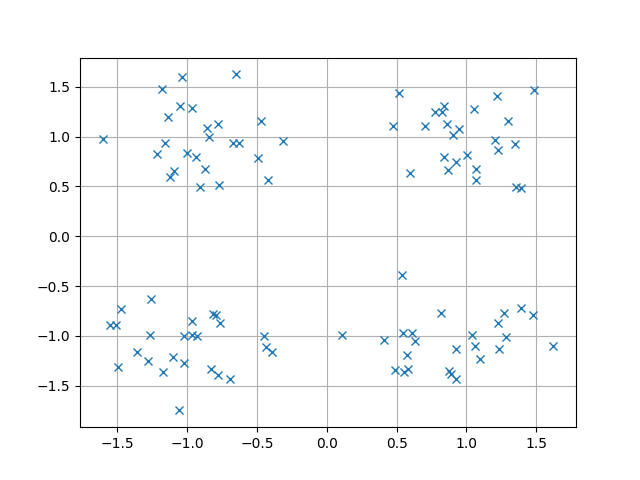

In [4]:
plot.figure()
plot.plot(x[:,0], x[:,1], 'x')
plot.grid('on')
plot.show()

In [5]:
K = 4

k-Means is a heuristic algorithm that finds the near-optimal clusters and their means by iteratively improving its guesses.  It does so by starting with an initial guess of cluster means, then alternate between:
* Assigning the data points to the nearest cluster mean, and
* Updating the cluster mean according to the assignments.

<IPython.core.display.Javascript object>


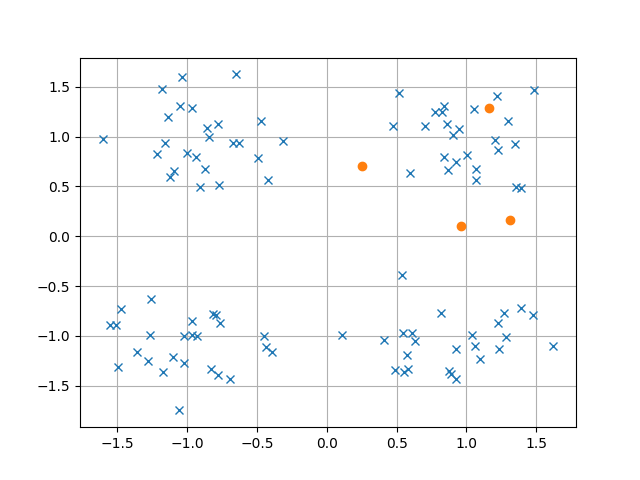

In [6]:
# Initial guess.  We don't want to have our guess horribly far away from the dataset.
W = numpy.random.rand(K, n_dim) * 1.5
plot.figure()
plot.plot(x[:,0], x[:,1], 'x')
plot.plot(W[:,0], W[:,1], 'o')
plot.grid('on')
plot.show()

In [7]:
colors = ['r', 'g', 'b', 'k', 'm']

def plot_clusters(x, W, Z, K):
    plot.figure()
    for kk in xrange(K):
        plot.plot(x[Z == kk,0], x[Z == kk,1], colors[kk]+'x')
        plot.plot(W[kk,0], W[kk,1], colors[kk]+'o')
    plot.grid('on')
    plot.show()

<IPython.core.display.Javascript object>


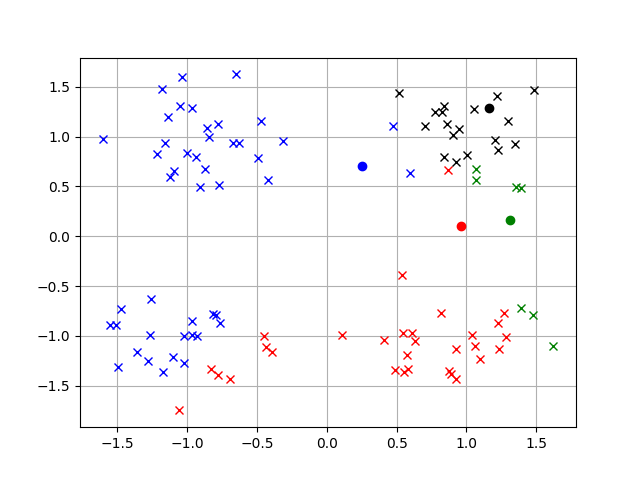

In [8]:
# first step: find the best assignment
def assign(W, x):
    return ((x[:,None,:] - W[None,:,:]) ** 2).sum(-1).argmin(-1)

Z = assign(W, x)
plot_clusters(x, W, Z, K)

<IPython.core.display.Javascript object>


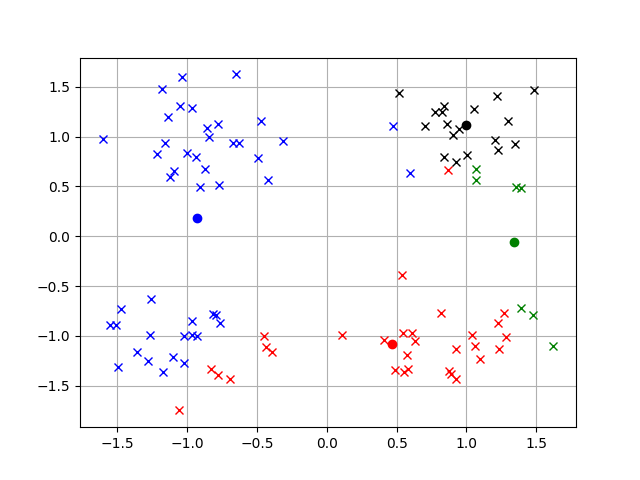

In [9]:
# second step: find the centroids
def update(Z, x, K):
    W = numpy.zeros((K, x.shape[1]))
    for kk in xrange(K):
        W[kk, :] = x[Z==kk,:].mean(0)
    return W

W = update(Z, x, K)
plot_clusters(x, W, Z, K)

<IPython.core.display.Javascript object>


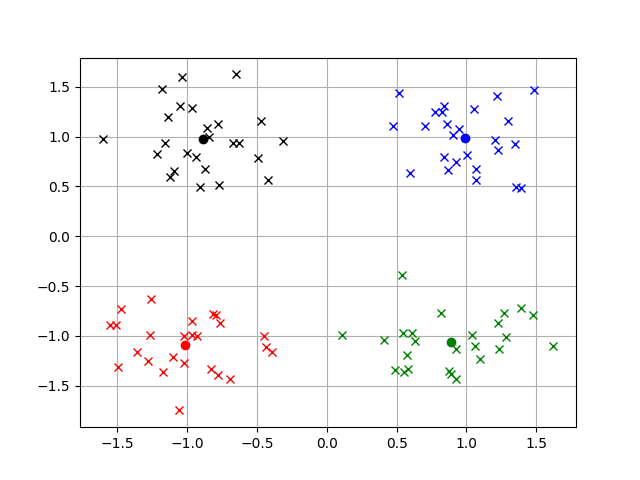

In [10]:
# Repeats the process

def kmeans(x, K):
    max_iter = 100
    eps = 1e-5
    W = numpy.random.rand(K, n_dim) * 1.5
    
    for _ in range(max_iter):
        W0 = numpy.copy(W)
        Z = assign(W, x)
        W = update(Z, x, K)
        if ((W - W0) ** 2).sum() < eps:
            break
            
    Z = assign(W, x)
    
    return W, Z

W, Z = kmeans(x, K)
plot_clusters(x, W, Z, K)

### How to pick a suitable k

We can inspect the dataset ourselves and see that the best number of clusters is 4.  However, in higher dimensional cases, it is not really possible to visualize the dataset, look with our own eyes, and choose the number.  So we need to quantify how well the k-Means clusters describe the variability of our data.

Consider having 2 or 5 clusters on the same dataset instead of 4:

<IPython.core.display.Javascript object>


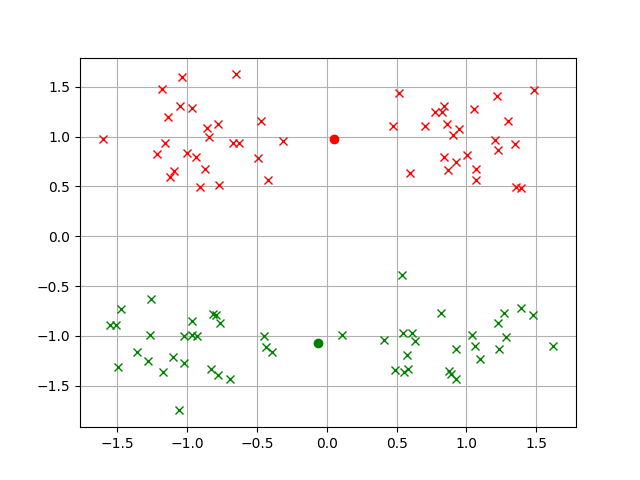

<IPython.core.display.Javascript object>


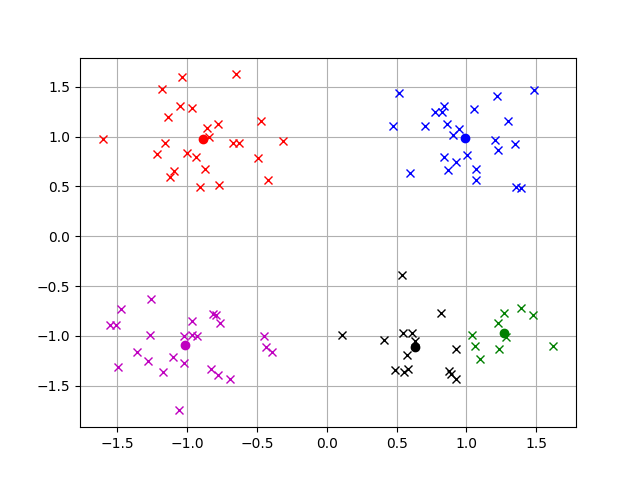

In [11]:
W, Z = kmeans(x, 2)
plot_clusters(x, W, Z, 2)

W, Z = kmeans(x, 5)
plot_clusters(x, W, Z, 5)

We can see that having 4 clusters explains the variability of the dataset better than having only 2, while 5 clusters does not explain the variability *significantly better* than having 4.

For k-Means, it is common to compute *inertia*, the sum of squared distances of samples to their corresponding cluster center.  By having more clusters, we expect the inertia to consistently decrease.  However, beyond a certain number of clusters, the decreases will be much less significant than the ones before.  We find the "optimal" number of clusters by finding this "turning point".  This algorithm is called *elbow method*.

In [12]:
def inertia(x, W, Z):
    return ((x - W[Z]) ** 2).sum()

<IPython.core.display.Javascript object>


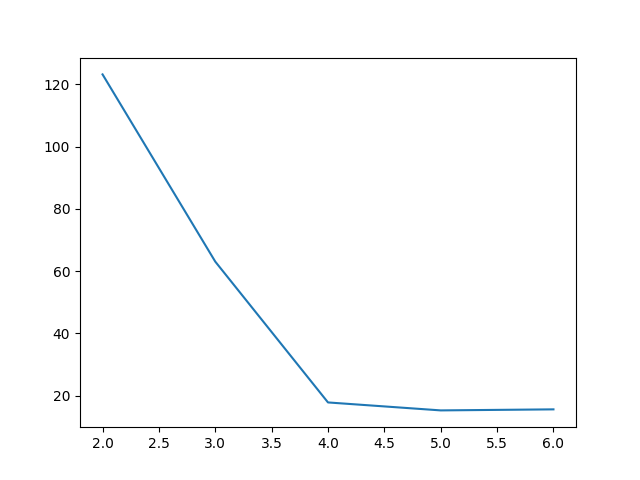

In [13]:
eps = 1e-5
max_iter = 100

i = []

for K in range(2, 7):
    W = numpy.random.rand(K, n_dim) * 1.5
    
    for _ in range(max_iter):
        W0 = numpy.copy(W)
        Z = assign(W, x)
        W = update(Z, x, K)
        if ((W - W0) ** 2).sum() < eps:
            break
            
    Z = assign(W, x)
    i.append(inertia(x, W, Z))
    
plot.figure()
plot.plot(range(2, 7), i)
plot.show()

### When does k-Means not work (that) well

Let's consider another dataset which has different-sized blobs (often called the "mouse" dataset).

In [14]:
x1 = numpy.random.randn(80, 2) * 0.4
x2 = numpy.random.randn(80, 2) * 0.1 + numpy.array([[-1, 1]])
x3 = numpy.random.randn(80, 2) * 0.1 + numpy.array([[1, 1]])
x = numpy.concatenate([x1, x2, x3])
Z = numpy.array([0] * 80 + [1] * 80 + [2] * 80)
W = numpy.array([[0, 0], [-1, 1], [1, 1]])

<IPython.core.display.Javascript object>


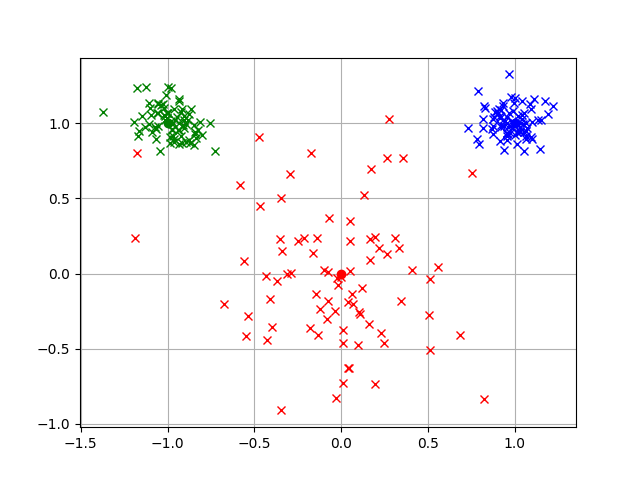

In [15]:
plot_clusters(x, W, Z, 3)

<IPython.core.display.Javascript object>


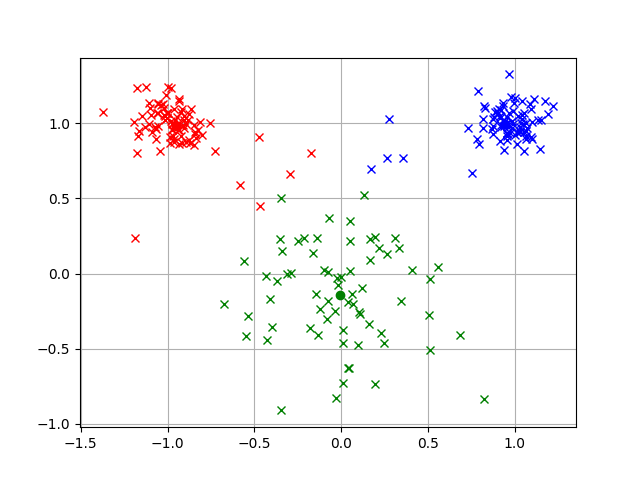

In [16]:
W, Z = kmeans(x, 3)
plot_clusters(x, W, Z, 3)

We can see that k-Means tend to assume that the blobs are of similar scale.  If that assumption does not hold, we may look at other clustering algorithms, such as Gaussian Mixture Models (not going through details here, and `scikit-learn` has it as well).